In [ ]:
!pip install protobuf==3.20.0

In [1]:
import sys
sys.path.append("/ibkr")

import os
import datetime
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pytz


import passwords
from databaseClass import DB
from utils import generate_df_from_sql_file, generate_list_from_sql_file
from utils import DataProcessor
from utils import ModelBuilder
from utils import Predictor
pd.set_option('display.max_rows', None)

2023-06-30 04:15:03.509658: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-30 04:15:03.530911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Restrict TensorFlow to only use the first GPU
    tf.config.set_visible_devices(gpus[0], 'GPU')

    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


2023-06-30 04:15:04.142356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 04:15:04.148447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 04:15:04.148589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvidia-smi

Fri Jun 30 04:15:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P2   114W / 350W |   2505MiB / 12288MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !pip install scikit-learn

In [5]:
userName = passwords.userName
userPass = passwords.userPass
dataBaseName = passwords.dataBaseName
host = passwords.host

In [6]:
db = DB(userName=userName, userPass=userPass, dataBaseName=dataBaseName, host='ibkr_db', docker=True)

In [7]:
db.tables

['tickdata_jun29']

In [8]:
input_sql_file='../sql_files/test.sql'
df = generate_df_from_sql_file(input_sql_file, db)

/ibkr/databaseClass.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)


In [9]:
df.head(10)

,ticktype,price,volume,timestamp
0,1,4434.75,0,2023-06-29 22:44:07.806861
1,2,4435.00,0,2023-06-29 22:44:07.818198
2,4,4435.00,0,2023-06-29 22:44:07.824383
3,5,0.00,1,2023-06-29 22:44:07.829809
4,5,0.00,1,2023-06-29 22:44:07.838547
5,5,0.00,11,2023-06-29 22:44:10.894014
6,1,4435.00,0,2023-06-29 22:44:10.920193
7,2,4435.25,0,2023-06-29 22:44:10.926092
8,4,4435.25,0,2023-06-29 22:44:25.667186
9,5,0.00,1,2023-06-29 22:44:25.687053


In [10]:
def main_build_model(df, look_ahead=5):
    
    df['timestamp'] = df['timestamp'].dt.tz_localize('UTC') #adding this to update to utc

    # Create a DataProcessor instance
    processor = DataProcessor(df) 
    # Process the df
    processor.process_df()
    
    # Scale and shift the data
    scaler, close_scaler = processor.scale_shift_data(look_ahead)
    # Create the X and y datasets
    X, y = processor.scaled_df, processor.shifted_df['Close']
    # Create train test split
    X_train, X_test, y_train, y_test = processor.create_train_test_split(X, y)   
    # Create final train and test datasets
    TIME_STEPS = 60
    X_train, y_train = processor.create_dataset(X_train, y=y_train, time_steps=TIME_STEPS, for_training=True, look_ahead=look_ahead)
    X_test, y_test = processor.create_dataset(X_test, y=y_test, time_steps=TIME_STEPS, for_training=True, look_ahead=look_ahead)

    # Number of features in the data
    n_features = X_train.shape[2]
    
    # Create a ModelBuilder instance and build the model
    builder = ModelBuilder(n_features, TIME_STEPS)
    # Train the model
    model, history = builder.train_model(X_train, y_train, X_test, y_test, epochs=20, batch_size=64)
    # Save the model
    model_path = '../models/model.h5'
    builder.save_model(model_path)
    # Plot loss
    builder.plot_loss(history)

Epoch 1/20


2023-06-30 04:15:23.306361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 04:15:23.307176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 04:15:23.307757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

74/74 [==============================] - 2s 13ms/step - loss: 0.0103 - val_loss: 0.0077
Epoch 2/20
74/74 [==============================] - 1s 12ms/step - loss: 0.0055 - val_loss: 0.0084
Epoch 3/20
74/74 [==============================] - 1s 12ms/step - loss: 0.0052 - val_loss: 0.0092
Epoch 4/20
74/74 [==============================] - 1s 12ms/step - loss: 0.0052 - val_loss: 0.0117
Epoch 5/20
74/74 [==============================] - 1s 12ms/step - loss: 0.0049 - val_loss: 0.0144
Epoch 6/20
74/74 [==============================] - 1s 11ms/step - loss: 0.0047 - val_loss: 0.0175
Epoch 7/20
74/74 [==============================] - 1s 11ms/step - loss: 0.0054 - val_loss: 0.0258
Epoch 8/20
74/74 [==============================] - 1s 12ms/step - loss: 0.0072 - val_loss: 0.0459
Epoch 9/20
74/74 [==============================] - 1s 12ms/step - loss: 0.0096 - val_loss: 0.0640
Epoch 10/20
74/74 [==============================] - 1s 12ms/step - loss: 0.0104 - val_loss: 0.0505
Epoch 11/20
74/74 [=

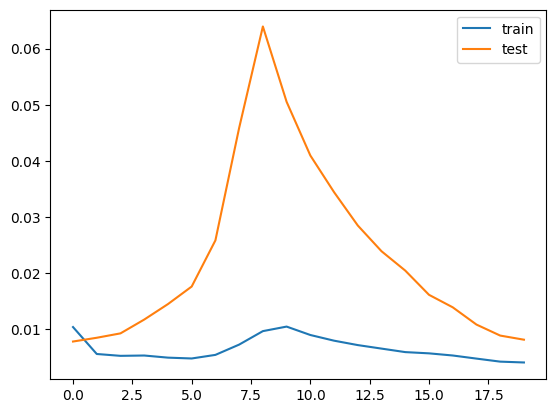

In [11]:
main_build_model(df, 5)

In [ ]:
df.head()

In [15]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [25]:
# Import TensorBoard
from tensorboard import notebook

# Start TensorBoard within the notebook using magics function
%load_ext tensorboard

# This line should start TensorBoard within the notebook
notebook.display(port=6006, height=100) 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
%reload_ext tensorboard

In [26]:
notebook.display()

ValueError: Can't display TensorBoard: no known instances running.